# Importing required libraries

In [2]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential # creating a linear stack of NN
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout 

# data manipulation
import pandas as pd
import numpy as np

# sklearn 
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder

# visualisation 
import cv2 
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import sys
import os
main_dir = os.path.dirname(sys.path[0])
print(main_dir)

d:\Coding


# Data Loading and Preprocessing

we will work on dataset that is partitioned by hospital, which contains:    
- training set:
    - glaucoma
    - normal
- test set: 
    - glaucoma
    - normal        
    
so i will create a separate training set and test set, and in each set, i will add glaucoma imgs and label also, then i will read, normal images and add them to the set and add `normal` label accordingly.

In [4]:
IMG_LOCATION = main_dir + "\\glaucoma-detection\\rim\\RIM-ONE_DL_images\\partitioned_by_hospital\\"
TRAINING_LOCATION = IMG_LOCATION + os.listdir(IMG_LOCATION)[1]
TESTING_LOCATION = IMG_LOCATION + os.listdir(IMG_LOCATION)[0]

In [5]:
def create_data_and_labels(path, label, data, labels):
    
    for img in os.listdir(path + "\\" + label):
        image = cv2.imread(path + "\\" + label + "\\" + img, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128,128))
        data.append(image)
        labels.append(label)
    return data, labels

X_train = []
y_train = []
X_train, y_train = create_data_and_labels(TRAINING_LOCATION, "glaucoma", X_train, y_train)
X_train, y_train = create_data_and_labels(TRAINING_LOCATION, "normal", X_train, y_train)

X_test = []
y_test = []
X_test, y_test = create_data_and_labels(TESTING_LOCATION, "glaucoma", X_test, y_test)
X_test, y_test = create_data_and_labels(TESTING_LOCATION, "normal", X_test, y_test)

X_train = np.array(X_train, dtype = "float") / 255

X_test = np.array(X_test, dtype = "float") / 255


Here, while reading a png while, 2 steps are done before storing them in data:
- `imread` used to read the file
- `cvtColor` is used to convert from BGR to RGB format, as matplotlib uses RGB scheme and OpenCV uses BGR scheme. I believe this is not necessary for the NN but it is just for plotting ahead
- `resize` to scale down the image as it would slow the NN.     

In [6]:
y_train = np.array(y_train, dtype = "object")
y_test = np.array(y_test, dtype = "object") 

enc = OrdinalEncoder()

y_train = enc.fit_transform(y_train.reshape(-1,1))
y_test = enc.fit_transform(y_test.reshape(-1,1))


After storing them in the list, they are converted to numpy array with standardised values for further processing.  
Labels are encoded using `OrdinalEncoder()`

In [7]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (311, 128, 128, 3)
Shape of y_train:  (311, 1)
Shape of X_test:  (174, 128, 128, 3)
Shape of y_test:  (174, 1)


In [8]:
y_train.shape

(311, 1)

Plotting images from the training dataset

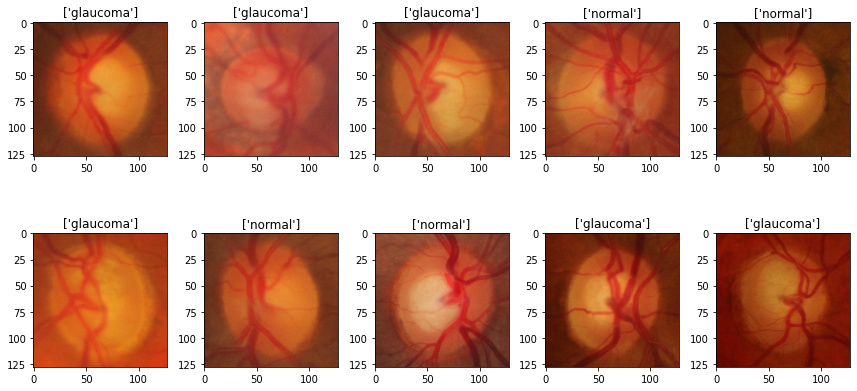

In [9]:
fig, axs = plt.subplots(2, 5, sharey= False, tight_layout = True, figsize = (12,6), facecolor = 'white')
pic = [13, 45, 23, 154, 299, 3, 123, 201, 100, 69]
k = 0
for i in range(0,2):
    for j in range(0, 5):
        n = pic[k]
        axs[i,j].imshow(X_train[n])
        axs[i,j].set(title = enc.inverse_transform(y_train)[n])
        k += 1
plt.show()

Now that we are done with preprocessing, We will now build our Neural network, which will convolution Neural Networks too.
# Specifying the Structure of Neural Network

In [10]:
## define a model
from itertools import dropwhile


model = Sequential(name= "DCN-Model")

# input layer
# specifying the shape 
model.add(Input(
    shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
    name = "Input-Layer"))

# First set of Conv, MaxPooling, Dropout Layer
model.add(Conv2D(
    filters = 16,
    kernel_size = (3,3),
    strides = (1,1),
    padding='valid',
    data_format = None, 
    dilation_rate = (1,1),
    groups = 1,
    activation = 'relu',
    use_bias = True,
    kernel_initializer='glorot_uniform',
    bias_initializer="zeros",
    kernel_regularizer = None, 
    bias_regularizer=None,
    activity_regularizer=None, 
    kernel_constraint= None,
    bias_constraint=None,
    name= '2D-Convolutional-Layer-1'
))

model.add(MaxPool2D(pool_size=(2,2),
strides=(2,2),
padding= 'valid',
data_format=None,
name='2D-MaxPool_layer-1'))

model.add(Dropout(0.2, name="Dropout-Layer-1"))

#--- second set of convolution, max pooling and droput layer
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides=(1,1), padding='valid', activation='relu', name='2D-Convolution-Layer'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding = 'valid', name = "2D-Max-Pool"))
model.add(Dropout(0.2, name="Dropout-Layer-2"))

# --- Third set of the same
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation= 'relu', name = '2D-Convolutional-Layer-3'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', name = '2D-MaxPooling-Layer'))
model.add(Dropout(0.2, name= "Dropout-Layer-3"))

#--- Feed-Forward Densely Connected Layer and Output Layer (note, flattening is required to convert from 2D to 1D shape)
model.add(Flatten(name='Flatten-Layer')) # Flatten the shape so we can feed it into a regular densely connected layer
model.add(Dense(16, activation='relu', name='Hidden-Layer-1', kernel_initializer='HeNormal')) # Hidden Layer, relu(x) = max(x, 0)
model.add(Dense(2, activation='softmax', name='Output-Layer')) # Output Layer, softmax(x) = exp(x) / tf.reduce_sum(exp(x))

# Compiling and Fitting the model into the dataset

In [11]:
#   Step 2 - Compile keras model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
    loss='SparseCategoricalCrossentropy', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
    metrics=['Accuracy'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
    loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
    weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
    run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
    steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
    )

# step 3 - fittting the dataaset into the model
history = model.fit(X_train, # input data
    y_train, # target data
    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
    epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
    verbose=0, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
    validation_split=0.0, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
    use_multiprocessing=False, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
    )

Now the model is fitted, and we predict the probabilities!

In [12]:
# we predict for training dataset first
pred_labels_tr = np.array(tf.math.argmax(model.predict(X_train),axis=1))
# Predict class labels on a test data
pred_labels_te = np.array(tf.math.argmax(model.predict(X_test),axis=1))


##### Step 5 - Model Performance Summary
print('------------------------- Model Summary -------------------------')
model.summary() # print model summary

6/6 [==============================] - 1s 117ms/step
------------------------- Model Summary -------------------------
Model: "DCN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2D-Convolutional-Layer-1 (C  (None, 126, 126, 16)     448       
 onv2D)                                                          
                                                                 
 2D-MaxPool_layer-1 (MaxPool  (None, 63, 63, 16)       0         
 ing2D)                                                          
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 63, 63, 16)        0         
                                                                 
 2D-Convolution-Layer (Conv2  (None, 61, 61, 64)       9280      
 D)                                                              
                                                                 
 2D-

In [13]:
print('------------------------- Encoded Names -------------------------')
for i in range(0,len(enc.categories_[0])):
    print(i,": ",enc.categories_[0][i])
print("")

print('------------------ Evaluation on Training Data ------------------')
# Print the last value in the evaluation metrics contained within history file
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")
# Print classification report
print(classification_report(y_train, pred_labels_tr))
print("")

------------------------- Encoded Names -------------------------
0 :  glaucoma
1 :  normal

------------------ Evaluation on Training Data ------------------
Final loss : 0.6610062718391418
Final Accuracy : 0.6270096302032471

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       116
         1.0       0.63      1.00      0.77       195

    accuracy                           0.63       311
   macro avg       0.31      0.50      0.39       311
weighted avg       0.39      0.63      0.48       311




c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [14]:
print('-------------------- Evaluation on Test Data --------------------')
print(classification_report(y_test, pred_labels_te))
print("")

-------------------- Evaluation on Test Data --------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        56
         1.0       0.68      1.00      0.81       118

    accuracy                           0.68       174
   macro avg       0.34      0.50      0.40       174
weighted avg       0.46      0.68      0.55       174




c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

The Accuracy for training dataset is 84% which is decent. whereas for Test dataset, the accuracy turns out to be 74% which needs improvement.
It can be improved by :
- increasing the size of dataset
- increasing the epochs


In [20]:
def predict_scan(filename):
    filepath = main_dir + '\\glaucoma-detection\\uploaded_images\\' + filepath
    
    print(filepath)
predict_scan('xyz')

d:\Coding\glaucoma-detection\uploaded_images\
